In [1]:
import sys
sys.path.append("../")
import os
import math
import numpy as np
import cv2
import pandas as pd
from scipy import stats
from pedrec.configs.dataset_configs import get_sim_dataset_cfg_default, get_h36m_dataset_cfg_default
from pedrec.datasets.pedrec_dataset import PedRecDataset
from pedrec.configs.pedrec_net_config import PedRecNet50Config
from pedrec.evaluations.validate import get_2d_pose_pck_results, get_3d_pose_results, get_orientation_results
from pedrec.evaluations.eval_np.eval_pose_2d import get_ref_distance_torso, get_normalized_joint_distances
from pedrec.models.constants.skeleton_pedrec import SKELETON_PEDREC_JOINTS, SKELETON_PEDREC, SKELETON_PEDREC_JOINT
from pedrec.models.constants.skeleton_coco import SKELETON_COCO_JOINTS
from pedrec.models.constants.dataset_constants import DatasetType
from pedrec.visualizers.skeleton_visualizer import draw_skeleton
from pedrec.visualizers.skeleton_3d_visualizer import add_skeleton_3d_to_axes
from pedrec.visualizers.orientation_visualizer import add_orientation_to_axes
from pedrec.visualizers.visualization_helper_3d import draw_grid_3d, draw_origin_3d
from pedrec.models.data_structures import ImageSize
from pedrec.utils.print_helper import get_heading
from pedrec.utils.pedrec_dataset_helper import get_filter_skeleton2d, get_filter_body_orientation, \
    get_filter_skeleton3d, get_filter_bb, get_filter_head_orientation, get_filter_env
from random import randint
import matplotlib.pyplot as plt

In [2]:
def print_pck_results(gt, pred, title):
  print("####################################################################")
  print(f"############## PCK results: {title} (num samples: {gt.shape[0]})")
  print("####################################################################")
  pose2d_pck = get_2d_pose_pck_results(gt, pred)
  pose2d_pck05_per_joint = pose2d_pck.pck_05
  pose2d_pck2_per_joint = pose2d_pck.pck_2
  pose2d_pck05_mean = pose2d_pck.pck_05_mean
  pose2d_pck2_mean = pose2d_pck.pck_2_mean

  for joint, pck05, pck2 in zip(SKELETON_COCO_JOINTS, pose2d_pck05_per_joint, pose2d_pck2_per_joint):
    print(f"{joint.name} | PCK@0.05: {pck05:.2f} | PCK@0.2: {pck2:.2f}")

  print(f"Mean: PCK@0.05: {pose2d_pck05_mean} | PCK@0.2: {pose2d_pck2_mean}")

In [3]:
def get_skel2d_coco(skeleton_2ds):
    skel_coco = np.zeros((skeleton_2ds.shape[0], 17, 5), dtype=np.float32)
    for idx, joint in enumerate(SKELETON_COCO_JOINTS):
        skel_coco[:, idx, :] = skeleton_2ds[:, joint.value, :]
    return skel_coco

In [4]:
def get_arrays(df: pd.DataFrame):
    filter_skeleton2d = get_filter_skeleton2d(df)
    filter_body_orientation = get_filter_body_orientation(df)

    skeleton2ds = df[filter_skeleton2d].to_numpy(dtype=np.float32).reshape(df.shape[0], len(SKELETON_PEDREC_JOINTS), 5)
    skeleton2ds = get_skel2d_coco(skeleton2ds)
    orientations = df[filter_body_orientation].to_numpy(dtype=np.float32).reshape(df.shape[0], 5)

    return skeleton2ds, orientations

In [5]:
df_results = pd.read_pickle("data/datasets/COCO/results/COCO_pred_df_experiment_pedrec_p2d3d_c_o_h36m_sim_mebow_0.pkl")
df = pd.read_pickle("data/datasets/COCO/results/COCO_gt_df_experiment_pedrec_p2d3d_c_o_h36m_sim_mebow_0.pkl")

print(len(df_results))
print(len(df))

6352
6352


In [6]:
pd.options.display.max_columns = None
pd.options.display.float_format= '{:.2f}'.format
df.head(50)
print(df.iloc[49]["img_path"])

data/datasets/COCO/val2017/000000312421.jpg


In [7]:
skeleton2ds, orientations = get_arrays(df)
skeleton2ds_pred, orientations_pred = get_arrays(df_results)

In [8]:
pck_results = print_pck_results(skeleton2ds, skeleton2ds_pred, "jo")

####################################################################
############## PCK results: jo (num samples: 6352)
####################################################################
nose | PCK@0.05: 84.76 | PCK@0.2: 98.21
left_eye | PCK@0.05: 88.45 | PCK@0.2: 98.32
right_eye | PCK@0.05: 87.44 | PCK@0.2: 98.32
left_ear | PCK@0.05: 80.91 | PCK@0.2: 97.89
right_ear | PCK@0.05: 78.04 | PCK@0.2: 97.36
left_shoulder | PCK@0.05: 51.13 | PCK@0.2: 94.52
right_shoulder | PCK@0.05: 50.72 | PCK@0.2: 94.29
left_elbow | PCK@0.05: 50.57 | PCK@0.2: 92.29
right_elbow | PCK@0.05: 50.23 | PCK@0.2: 91.97
left_wrist | PCK@0.05: 48.58 | PCK@0.2: 88.83
right_wrist | PCK@0.05: 50.43 | PCK@0.2: 89.27
left_hip | PCK@0.05: 23.49 | PCK@0.2: 87.46
right_hip | PCK@0.05: 23.28 | PCK@0.2: 87.71
left_knee | PCK@0.05: 38.26 | PCK@0.2: 86.89
right_knee | PCK@0.05: 37.13 | PCK@0.2: 87.60
left_ankle | PCK@0.05: 34.90 | PCK@0.2: 85.50
right_ankle | PCK@0.05: 35.04 | PCK@0.2: 85.51
Mean: PCK@0.05: 53.72718721277573 |

####################################################################
############## PCK results: Full (num samples: 6352)
####################################################################
nose | PCK@0.05: 84.76 | PCK@0.2: 98.21
left_eye | PCK@0.05: 88.45 | PCK@0.2: 98.32
right_eye | PCK@0.05: 87.44 | PCK@0.2: 98.32
left_ear | PCK@0.05: 80.91 | PCK@0.2: 97.89
right_ear | PCK@0.05: 78.04 | PCK@0.2: 97.36
left_shoulder | PCK@0.05: 51.13 | PCK@0.2: 94.52
right_shoulder | PCK@0.05: 50.72 | PCK@0.2: 94.29
left_elbow | PCK@0.05: 50.57 | PCK@0.2: 92.29
right_elbow | PCK@0.05: 50.23 | PCK@0.2: 91.97
left_wrist | PCK@0.05: 48.58 | PCK@0.2: 88.83
right_wrist | PCK@0.05: 50.43 | PCK@0.2: 89.27
left_hip | PCK@0.05: 23.49 | PCK@0.2: 87.46
right_hip | PCK@0.05: 23.28 | PCK@0.2: 87.71
left_knee | PCK@0.05: 38.26 | PCK@0.2: 86.89
right_knee | PCK@0.05: 37.13 | PCK@0.2: 87.60
left_ankle | PCK@0.05: 34.90 | PCK@0.2: 85.50
right_ankle | PCK@0.05: 35.04 | PCK@0.2: 85.51
Mean: PCK@0.05: 53.72718721277573

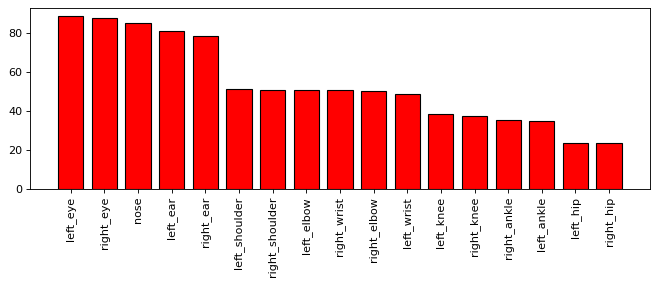

In [9]:
import tikzplotlib
def print_pck_results(gt, pred, title):
  print("####################################################################")
  print(f"############## PCK results: {title} (num samples: {gt.shape[0]})")
  print("####################################################################")
  pose2d_pck = get_2d_pose_pck_results(gt, pred)
  pose2d_pck05_per_joint = pose2d_pck.pck_05
  pose2d_pck2_per_joint = pose2d_pck.pck_2
  pose2d_pck05_mean = pose2d_pck.pck_05_mean
  pose2d_pck2_mean = pose2d_pck.pck_2_mean

  for joint, pck05, pck2 in zip(SKELETON_COCO_JOINTS, pose2d_pck05_per_joint, pose2d_pck2_per_joint):
    print(f"{joint.name} | PCK@0.05: {pck05:.2f} | PCK@0.2: {pck2:.2f}")

  print(f"Mean: PCK@0.05: {pose2d_pck05_mean} | PCK@0.2: {pose2d_pck2_mean}")

  names = []
  for joint in SKELETON_COCO_JOINTS:
    names.append(joint.name)
  names = [x for _, x in sorted(zip(pose2d_pck05_per_joint, names), reverse=True)]
  pose2d_pck05_per_joint = sorted(pose2d_pck05_per_joint, reverse=True)

  plt.figure(figsize=(10, 3), dpi=80)
  plt.xticks(rotation=90)

  plt.bar(names, pose2d_pck05_per_joint, width=0.75, color="red", edgecolor = 'black')
  plt.xticks([r for r in range(len(names))], names)
  # plt.xticks([r + bar_width for r in range(len(names))], names)
  # plt.legend()
  # ax.bar(names, pose3d_results.mean_joint_y_distances, color="g")
  xmin, xmax, ymin, ymax = plt.axis()
  tikzplotlib.save("/home/dennis/Downloads/coco_val_results_pck05_barchart.tex", extra_axis_parameters={
    'width=\\textwidth',
    'title={COCO val2017 $PCK@.05$ results}',
    'enlarge y limits=0.001',
    'xticklabel style={font=\\footnotesize}',
  })

print_pck_results(skeleton2ds, skeleton2ds_pred, "Full")


In [10]:
orientations[:, 1] *= 2*math.pi
orientations_pred[:, 1] *= 2*math.pi


In [11]:
mask = orientations[:, 4] == 1
phi_gt = np.degrees(orientations[:, 1])[mask]
phi_pred = np.degrees(orientations_pred[:, 1])[mask]
img_paths = df["img_path"][mask]

def get_angular_distance(phi_gt_deg, phi_pred_deg):
    dist_phi = np.abs(phi_pred_deg - phi_gt_deg)
    return np.minimum(360 - dist_phi, dist_phi)

dist_phi_body = get_angular_distance(phi_gt, phi_pred)

In [12]:
print(np.mean(dist_phi_body))
print(np.max(dist_phi_body))

10.048433
179.19379


In [13]:
new_mask = dist_phi_body >= 45
print(np.sum(new_mask))

168


In [14]:
img_paths = img_paths[new_mask]
phi_pred = phi_pred[new_mask]
phi_gt = phi_gt[new_mask]


In [15]:
from pedrec.configs.dataset_configs import CocoDatasetConfig, get_coco_dataset_cfg_default
from pedrec.datasets.coco_dataset import CocoDataset

cfg = PedRecNet50Config()
dataset_cfg = get_coco_dataset_cfg_default()
dataset_cfg.rotation_factor = 0
dataset_cfg.use_mebow_orientation = True
# MS Coco
dataset_name = "MSCOCO"
dataset = CocoDataset("data/datasets/COCO", DatasetType.VALIDATE, dataset_cfg,
                      cfg.model.input_size, None)


loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


129.9999976158142
130.0
26.954811


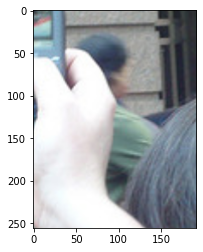

In [19]:
dataset_index = img_paths.index[3]
model_input, labels = dataset[dataset_index]
orientation_gt = labels["orientation"]
orientation_phi = orientation_gt[0, 1] * 2 * math.pi
print(math.degrees(orientation_phi))
print(phi_gt[3])
print(phi_pred[3])
plt.imshow(model_input)

In [33]:
from pathlib import Path
for idx, dataset_index in enumerate(img_paths.index):
  model_input, labels = dataset[dataset_index]
  orientation_gt = labels["orientation"]
  orientation_phi = orientation_gt[0, 1] * 2 * math.pi
  # print(math.degrees(orientation_phi))
  # print(phi_pred[idx])
  img = cv2.cvtColor(model_input, cv2.COLOR_RGB2BGR)
  filename = f"{Path(img_paths[dataset_index]).stem}-{int(math.degrees(orientation_phi))}-{int(phi_pred[idx])}"
  path = f"/home/dennis/Documents/COCOMEBOW_FALSEDETS/{filename}.jpg"
  print(path)
  cv2.imwrite(path, img)
  # plt.imshow(model_input)



/home/dennis/Documents/COCOMEBOW_FALSEDETS/000000312421-330-227.jpg
/home/dennis/Documents/COCOMEBOW_FALSEDETS/000000078915-80-348.jpg
/home/dennis/Documents/COCOMEBOW_FALSEDETS/000000326541-124-237.jpg
/home/dennis/Documents/COCOMEBOW_FALSEDETS/000000326541-129-26.jpg
/home/dennis/Documents/COCOMEBOW_FALSEDETS/000000363207-124-74.jpg
/home/dennis/Documents/COCOMEBOW_FALSEDETS/000000507223-25-280.jpg
/home/dennis/Documents/COCOMEBOW_FALSEDETS/000000099054-30-158.jpg
/home/dennis/Documents/COCOMEBOW_FALSEDETS/000000570539-339-25.jpg
/home/dennis/Documents/COCOMEBOW_FALSEDETS/000000260470-330-284.jpg
/home/dennis/Documents/COCOMEBOW_FALSEDETS/000000201072-285-96.jpg
/home/dennis/Documents/COCOMEBOW_FALSEDETS/000000172946-280-342.jpg
/home/dennis/Documents/COCOMEBOW_FALSEDETS/000000172946-50-359.jpg
/home/dennis/Documents/COCOMEBOW_FALSEDETS/000000120420-70-218.jpg
/home/dennis/Documents/COCOMEBOW_FALSEDETS/000000150265-104-294.jpg
/home/dennis/Documents/COCOMEBOW_FALSEDETS/000000066038-3